In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"samuxiii","key":"***************"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
!unzip -qo the-simpsons-characters-dataset.zip -d data

 99% 1.06G/1.08G [00:24<00:00, 37.3MB/s]
100% 1.08G/1.08G [00:24<00:00, 46.8MB/s]


In [25]:
# Remove duplicated folders
!rm -rf data/simpsons_dataset/simpsons_dataset
!mv data/kaggle_simpson_testset/kaggle_simpson_testset/* data/kaggle_simpson_testset/
!rm -rf data/kaggle_simpson_testset/kaggle_simpson_testset

In [47]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from os import listdir
from PIL import Image
from imageio import imread
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [26]:
#configure train dataset
train_root_path = "./data/simpsons_dataset"
character_directories = listdir(train_root_path)
print("Name directories for training: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./data/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
print("Sample of test images: {}".format(test_image_names[:5]))


Name directories for training: ['lisa_simpson', 'patty_bouvier', 'troy_mcclure', 'nelson_muntz', 'kent_brockman']
Sample of test images: ['sideshow_bob_4.jpg', 'homer_simpson_15.jpg', 'krusty_the_clown_2.jpg', 'moe_szyslak_21.jpg', 'apu_nahasapeemapetilon_41.jpg']


### Showing a Test Sample

Id: 720, Image Label: milhouse_van_houten, Shape: (171, 229, 3)


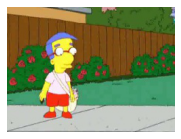

In [27]:
num_test_images = len(test_image_names)

idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)

print("Id: {}, Image Label: {}, Shape: {}".format(idx, '_'.join(sample_name), sample_image.shape))
plt.figure(figsize=(3,3))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

### Finding a Valid Image Size

Not all the images have the same size dimensions so the first thing we'll have to do will be to rescale them. That's because the model will only accept a specific image size. The strategy to find out this value will be averaging the size in the test dataset.

After that, the whole training set will be rescaled as well using this value.

In [28]:
width = 0
height = 0

for i in range(num_test_images):
    path_file = os.path.join(test_root_path, test_image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    height += image.shape[1]

width_mean = width//num_test_images
height_mean = height//num_test_images
dim_size = (width_mean + height_mean) // 2

print("Width (mean): {}".format(width_mean))
print("height (mean): {}".format(height_mean))
print("Input image size: {}".format(dim_size))

Width (mean): 148
height (mean): 147
Input image size: 147


### Utils for Creating Batches

During the training stage it's not a good idea to load the whole set of images in the memory since we might run out of memory. Thus, we'll need a generator that give us batches of images to keep it in memory until we don't need it anymore.

In [31]:
def imresize(im):
    return np.array(Image.fromarray(im).resize((dim_size, dim_size)))

def get_num_of_samples():
    count = 0
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        count += len(listdir(path))
        
    return count

def get_batch(batch_init, batch_size):
    data = {'image':[], 'label':[]}
    character_batch_size = batch_size//len(character_directories)
    character_batch_init = batch_init//len(character_directories)
    character_batch_end = character_batch_init + character_batch_size
    
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        images_list = listdir(path)
        for i in range(character_batch_init, character_batch_end):
            if len(images_list) == 0:
                continue
            #if this character has small number of features
            #we repeat them
            if i >= len(images_list):
                p = i % len(images_list)
            else:
                p = i
                
            path_file = os.path.join(path, images_list[p])
            image = imread(path_file)
            #all with the same shape
            image = imresize(image)
            data['image'].append(image)
            data['label'].append(character)
    
    return data

def get_batches(num_batches, batch_size, verbose=False):
    #num max of samples
    num_samples = get_num_of_samples()
    #check number of batches with the maximum
    max_num_batches = num_samples//batch_size - 1
    
    if verbose:
        print("Number of samples:{}".format(num_samples))
        print("Batches:{} Size:{}".format(num_batches, batch_size))
    assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
        
    for i in range(0, num_batches):
        init = i * batch_size
        if verbose:
            print("Batch-{} yielding images from {} to {}...".format(i, init, init+batch_size))
        
        yield get_batch(init, batch_size)

Testing the batches methods:

In [37]:
#testing generator
batch_size = 500

for b in get_batches(3, batch_size, verbose=True):
    print("\t|- retrieved {} images".format(len(b['image'])))

Number of samples:20933
Batches:3 Size:500
Batch-0 yielding images from 0 to 500...
	|- retrieved 462 images
Batch-1 yielding images from 500 to 1000...
	|- retrieved 462 images
Batch-2 yielding images from 1000 to 1500...
	|- retrieved 462 images


### Preprocessing data

In [38]:
#num characters
num_characters = len(character_directories)

#normalize
def normalize(x):
    #we use the feature scaling to have all the batches
    #in the same space, that is (0,1)
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

#one-hot encode
lb = preprocessing.LabelBinarizer()
lb = lb.fit(character_directories)

def one_hot(label):
    return lb.transform([label])


### Storing preprocessed batches on disk

In [39]:
num_batches = 40
batch_size = 500

In [40]:
cnt_images = 0
for cnt, b in enumerate(get_batches(num_batches, batch_size)):
    data = {'image':[], 'label':[]}
    
    for i in range( min(len(b['image']), batch_size) ):
        image = np.array( b['image'][i] )
        label = np.array( b['label'][i] )
        #label = label.reshape([-1,:])
        if len(image.shape) == 3:
          data['image'].append(normalize(image))
          data['label'].append(one_hot(label)[-1,:])
          cnt_images += 1
        else:
          print("Dim image < 3")
    
    with open("simpson_train_{}.pkl".format(cnt), 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    
print("Loaded {} train images and stored on disk".format(cnt_images))

Loaded 18480 train images and stored on disk


In [41]:
#testing load from file
with open('simpson_train_0.pkl', 'rb') as file:
    data = pickle.load(file)
    print("Example of onehot encoded:\n{}".format(data['label'][0]))
    print("Data shape: {}".format(data['image'][0].shape))

Example of onehot encoded:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Data shape: (147, 147, 3)


###NOTE
Since here the data is already processed and saved as pickle files.

### Building the Network

In [44]:
#helpers
def convolution(inputs, kernel_shape, stride_shape, output_depth):
    #convolution variables
    input_depth = inputs.get_shape().as_list()[3]
    filter_shape = kernel_shape + (input_depth, output_depth)
    dev = 1/np.sqrt(kernel_shape[0]*kernel_shape[1])
    filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=dev), name="filter_")
    stride_shape = (1,) + stride_shape + (1,)
    pool_shape = stride_shape
    bias_ = tf.Variable(tf.truncated_normal([output_depth], stddev=dev), name="bias_")
    
    #convolution
    x = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    x = tf.nn.bias_add(x, bias_)
    x = tf.nn.relu(x)
    #x = tf.nn.conv2d(inputs, filter_, stride_shape, padding='SAME')
    #x = tf.nn.bias_add(x, bias_)
    #x = tf.nn.relu(x)
    
    #pooling
    x = tf.nn.max_pool(x, pool_shape, stride_shape, padding='SAME')
    
    return x

def classifier(inputs, num_outputs):
    #classifier variables
    num_inputs = inputs.get_shape().as_list()[1]
    dev = 1/np.sqrt(num_inputs)
    weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=dev), name="weights")
    bias = tf.Variable(tf.truncated_normal(num_outputs, stddev=dev), name="bias")

    #classifier
    logits = tf.add(tf.matmul(inputs, weights), bias)

    return logits

In [49]:
##building the network

#remove previous weights, bias, etc
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 


tf.reset_default_graph()

#shape
image_shape = (dim_size, dim_size, 3)
label_shape = (num_characters,)

#data
X = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.float32, (None,) + label_shape)

#conv
print(X.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 32)
print(conv.get_shape().as_list())
conv = convolution(X, (5,5), (2,2), 64)
print(conv.get_shape().as_list())
conv = convolution(conv, (5,5), (2,2), 128)
print(conv.get_shape().as_list())
    
#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifying
num_outputs = label_shape
logits = classifier(flatten, (40,))
logits = tf.nn.dropout(logits, 0.8)
logits = classifier(logits, num_outputs)

print("Inputs shape: {}".format(X.get_shape().as_list()[1:]))
print("Flatten shape: {}".format(flatten_shape))
print("Outputs shape: {}".format(logits.get_shape().as_list()[1]))

Instructions for updating:
non-resource variables are not supported in the long term
[None, 147, 147, 3]
[None, 37, 37, 32]
[None, 37, 37, 64]
[None, 10, 10, 128]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Inputs shape: [147, 147, 3]
Flatten shape: 12800
Outputs shape: 42


In [50]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [52]:
##Train the model
x_train = []
y_train = []
x_val = []
y_val = []

##
epochs = 30

sess = tf.Session()
sess.run(tf.global_variables_initializer())

stats = {'train_loss':[], 'val_loss':[], 'acc':[]}

for e in range(epochs):
    
    for i in range(num_batches):
        fname = "simpson_train_{}.pkl".format(i)
        if os.path.exists(fname):   
            with open(fname, 'rb') as file:
                #print("Processing: {}".format(fname))
                data = pickle.load(file)
                x_train, x_val, y_train, y_val = train_test_split(data['image'], data['label'], test_size=0.2, random_state=42)

                feed_dict = {X: x_train, y: y_train}
                train_loss, _ = sess.run([cost, optimizer], feed_dict)

                feed_dict = {X: x_val, y: y_val}
                val_loss, acc = sess.run([cost, accuracy], feed_dict)

                #storing stats
                stats['train_loss'].append(train_loss)
                stats['val_loss'].append(val_loss)
                stats['acc'].append(acc)
                
                #enough accuracy
                if acc > 0.8:
                  break
                
    print("Epoch:{} Training Loss:{:.4f} Validation Loss:{:.4f} Accuracy:{:.4f}".format(e, train_loss, val_loss, acc))
    
    #stop epochs
    if acc > 0.8:
      break


Epoch:0 Training Loss:2.8699 Validation Loss:3.0191 Accuracy:0.2473
Epoch:1 Training Loss:1.7104 Validation Loss:1.9779 Accuracy:0.5269
Epoch:2 Training Loss:1.2330 Validation Loss:1.7368 Accuracy:0.5376
Epoch:3 Training Loss:0.9474 Validation Loss:1.5810 Accuracy:0.5914
Epoch:4 Training Loss:0.7980 Validation Loss:1.4311 Accuracy:0.6882
Epoch:5 Training Loss:0.6325 Validation Loss:1.4136 Accuracy:0.7097
Epoch:6 Training Loss:0.5504 Validation Loss:1.3419 Accuracy:0.7097
Epoch:7 Training Loss:0.4762 Validation Loss:1.4134 Accuracy:0.7204
Epoch:8 Training Loss:0.4409 Validation Loss:1.4044 Accuracy:0.6989
Epoch:9 Training Loss:0.3726 Validation Loss:1.6019 Accuracy:0.7419
Epoch:10 Training Loss:0.3653 Validation Loss:1.1609 Accuracy:0.8065


In [55]:
with open("stats.pkl", 'wb') as file:
        pickle.dump(stats, file, pickle.HIGHEST_PROTOCOL)

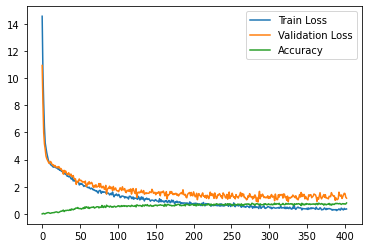

In [56]:
#don't plot the first 7 stats, they're in a big scale
plt.plot(stats['train_loss'][7:], label='Train Loss')
plt.plot(stats['val_loss'][7:], label='Validation Loss')
plt.plot(stats['acc'][7:], label='Accuracy')
plt.legend()

### Testing model

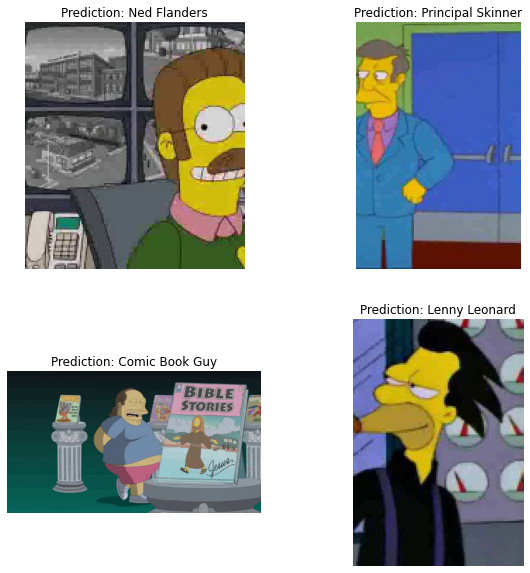

In [76]:
def test():
    idx = random.randint(0, num_test_images)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)
        
    test_image = sample_image
    test_label = ' '.join([s.capitalize() for s in sample_name])

    test_image_norm = normalize(imresize(sample_image))

    prediction = sess.run(logits, {X:[test_image_norm]})
    prediction = lb.inverse_transform(prediction)

    #showing
    #print("Label: {}".format(test_label))
    prediction = ' '.join([s.capitalize() for s in prediction[0].split('_')])
    #print("Prediction: {}".format(prediction))

    return test_image, test_label, prediction

# Execute and show
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    test_image, test_label, prediction = test()
    ax.set_title("Prediction: {}".format(test_label))
    ax.imshow(test_image)
    ax.axis('off')
plt.show()
